In [8]:
import time

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score
import joblib
import pandas as pd
import numpy as np

In [2]:
"""
线性回归直接预测房子价格
:return: None
"""
# 获取数据
lb = fetch_california_housing(data_home='data')

print("获取特征值")
print(lb.data.shape)
print(lb.data[0])
# print("目标值")
# print(lb.target)
# print(lb.DESCR)
print(lb.feature_names)
print('-' * 50)
# 分割数据集到训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(lb.data, lb.target, test_size=0.25, random_state=1)
#
print(x_train.shape)

获取特征值
(20640, 8)
[   8.3252       41.            6.98412698    1.02380952  322.
    2.55555556   37.88       -122.23      ]
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
--------------------------------------------------
(15480, 8)


In [5]:
y_train

array([1.034, 1.114, 2.164, ..., 1.048, 1.407, 1.26 ])

In [4]:
# # 进行标准化处理(?) 目标值处理？
# # 特征值和目标值是都必须进行标准化处理, 实例化两个标准化API
std_x = StandardScaler()
#
std_x.fit(x_train) #计算均值和方差
# # 对训练集和测试集的特征值进行标准化
x_train = std_x.transform(x_train)
# x_train = std_x.fit_transform(x_train)
x_test = std_x.transform(x_test)

# 目标值进行了标准化,也可以不进行标准化
std_y = StandardScaler()
#
temp = y_train.reshape(-1, 1) #-1代表把剩余的元素都堆到哪一维
temp

array([[1.034],
       [1.114],
       [2.164],
       ...,
       [1.048],
       [1.407],
       [1.26 ]])

In [6]:
#这个单元格不能运行多次
#标签进行标准化
# 目标值是一维的，这里需要传进去2维的
y_train = std_y.fit_transform(y_train.reshape(-1, 1))
print(y_train.shape)
y_test = std_y.transform(y_test.reshape(-1, 1))
print(y_test.shape)

(15480, 1)
(5160, 1)


In [3]:
test1=np.array([1,2,3])
test1.reshape(-1,1)

array([[1],
       [2],
       [3]])

In [9]:
# # estimator预测
# # # 正规方程求解方式预测结果，正规方程进行线性回归
lr = LinearRegression()
# fit是耗时的
start=time.time()
lr.fit(x_train, y_train)
end=time.time()
print('耗时',end-start) #训练耗费时间
#回归系数可以看特征与目标之间的相关性,每个特征都有一个回归系数
print('回归系数', lr.coef_)
#
y_predict = lr.predict(x_test)
# 预测测试集的房子价格，通过inverse得到真正的房子价格
y_lr_predict = std_y.inverse_transform(y_predict)
# 保存训练好的模型，模型中保存的是w的值，也保存了模型结构
#保存模型放在fit之后即可
joblib.dump(lr, "./tmp/test.pkl")
print("正规方程  测试集里面每个房子的预测价格：", y_lr_predict[0:10])
#下面是求测试集的损失，也就是均方误差，求平方和再求平均
print("正规方程的均方误差：", mean_squared_error(y_test, y_predict))

耗时 0.020986318588256836
回归系数 [[ 0.71942632  0.10518431 -0.23147194  0.26802332 -0.00448136 -0.03495117
  -0.7849086  -0.76307353]]
正规方程  测试集里面每个房子的预测价格： [[2.12391852]
 [0.93825754]
 [2.7088455 ]
 [1.70873764]
 [2.82954754]
 [3.50376456]
 [3.0147162 ]
 [1.62781292]
 [1.74317518]
 [2.01897806]]
正规方程的均方误差： 0.40082431136214197


# 2 加载保存的模型

In [10]:
model = joblib.load("./tmp/test.pkl")
# # 因为目标值进行了标准化，一定要把预测后的值逆向转换回来
y_predict = model.predict(x_test)

#
print("保存的模型预测的结果：", y_predict)
print("正规方程的均方误差：", mean_squared_error(y_test, y_predict))

print("正规方程inverse后的均方误差：", mean_squared_error(std_y.inverse_transform(y_test),
                                               std_y.inverse_transform(y_predict)))

保存的模型预测的结果： [[ 0.039975  ]
 [-0.9856667 ]
 [ 0.54595901]
 ...
 [-0.72237246]
 [ 0.57093569]
 [-0.27655325]]
正规方程的均方误差： 0.40082431136214197
正规方程inverse后的均方误差： 0.5356532845422556


In [13]:
#理解均方误差
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_squared_error(y_true, y_pred)

0.375

In [14]:
#人工求均方误差
(np.square(3 - 2.5) + np.square(0.5) + 1) / 4

0.375

In [24]:
# 梯度下降去进行房价预测,数据量大要用这个
# learning_rate设置为不同的字符串，代表学习率变化的算法不一样
# eta0 是learning_rate的初始值
# learning_rate='optimal',alpha是正则化力度，但是会影响学习率的值，由alpha来算学习率
# penalty代表正则化，分为l1和l2
#每次训练得到损失不一样，是因为w每次随机的初始值不一样
sgd = SGDRegressor(eta0=0.01, penalty='l1',learning_rate='invscaling')
# # 训练
sgd.fit(x_train, y_train)
#回归系数可以看特征与目标之间的相关性,每个特征都有一个回归系数
print('梯度下降的回归系数', sgd.coef_)
#
# 预测测试集的房子价格
y_sgd_predict = std_y.inverse_transform(sgd.predict(x_test).reshape(-1, 1))
y_predict = sgd.predict(x_test)
# print("梯度下降测试集里面每个房子的预测价格：", y_sgd_predict)
print("梯度下降的均方误差：", mean_squared_error(y_test, y_predict))
print("梯度下降的原始房价量纲均方误差：", mean_squared_error(std_y.inverse_transform(y_test), y_sgd_predict))

梯度下降的回归系数 [ 0.7174137   0.11058616 -0.2427455   0.27061245 -0.00126155  0.
 -0.76053426 -0.76455919]
梯度下降的均方误差： 0.4026934849836158
梯度下降的原始房价量纲均方误差： 0.5381512093470652


C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#3 岭回归

In [28]:
# # # 岭回归去进行房价预测
#alpha就是补偿的系数
#正规方程求解，加补偿就可以让正规方程可逆
rd = Ridge(alpha=0.02)

rd.fit(x_train, y_train)

print(rd.coef_)
#
# # 预测测试集的房子价格
print(rd.predict(x_test).shape)
y_rd_predict = std_y.inverse_transform(rd.predict(x_test))
y_predict = rd.predict(x_test)
# print("岭回归里面每个房子的预测价格：", y_rd_predict)

print("岭回归的均方误差：", mean_squared_error(y_test, y_predict))
print("岭回归的均方误差：", mean_squared_error(std_y.inverse_transform(y_test), y_rd_predict))

[[ 0.71942576  0.10518585 -0.23146889  0.26801931 -0.00448083 -0.03495127
  -0.78489401 -0.76305881]]
(5160, 1)
岭回归的均方误差： 0.400824186685544
岭回归的均方误差： 0.5356531179270396


In [25]:
# # # Lasso回归去进行房价预测
#alpha就是补偿的系数
print(x_train.shape)
print(y_train.shape)
ls = Lasso(alpha=0.001)

ls.fit(x_train, y_train)

print(ls.coef_)
#
# # 预测测试集的房子价格
print(ls.predict(x_test).shape)
print('-'*50)
y_ls_predict = std_y.inverse_transform(ls.predict(x_test).reshape(-1,1))
y_predict = ls.predict(x_test)
# print("Lasso回归里面每个房子的预测价格：", y_rd_predict)
#
print("Lasso回归的均方误差：", mean_squared_error(y_test, y_predict))
print("Lasso回归的均方误差：", mean_squared_error(std_y.inverse_transform(y_test), y_ls_predict))

(15480, 8)
(15480, 1)
[ 0.71431792  0.10613811 -0.21758465  0.25415162 -0.00311065 -0.03403136
 -0.77399969 -0.75154125]
(5160,)
--------------------------------------------------
Lasso回归的均方误差： 0.40081302952916903
Lasso回归的均方误差： 0.5356382077349954


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6352\2283524880.py:3: RuntimeWarning: divide by zero encountered in log2
  plt.plot(x,-np.log2(x))


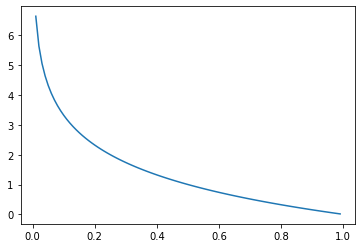

In [18]:
x=np.arange(0,1,0.01)
import matplotlib.pyplot as plt
plt.plot(x,-np.log(x))  #以e为底部
plt.show()

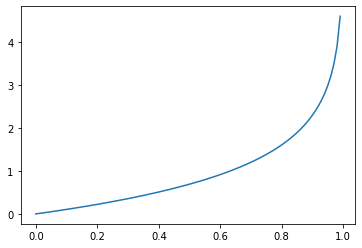

In [34]:
x=np.arange(0,1,0.01)
import matplotlib.pyplot as plt
plt.plot(x,-np.log(1-x))
plt.show()

In [37]:
"""
逻辑回归做二分类进行癌症预测（根据细胞的属性特征）
:return: NOne
"""
# 构造列标签名字
column = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
          'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli',
          'Mitoses', 'Class']

# 读取数据
data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
    names=column)

# print(data) #想看可以解除
#当你读取数据时，看上去是数值的列，读进来是字符串，说明里边
# 存在了非数值情况
print(data.info())
print(data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Uniformity of Cell Size      699 non-null    int64 
 3   Uniformity of Cell Shape     699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
None
        Sample code number  Clump Thickness  Uniformity of Cell Size  \
count         6.990000e+0

In [38]:
data['Bare Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [39]:
# 缺失值进行处理
data = data.replace(to_replace='?', value=np.nan)
#直接删除，哪一行有空值，就删除对应的样本
data = data.dropna()
print('-' * 50)
print(data.shape)

--------------------------------------------------
(683, 11)


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           683 non-null    int64 
 1   Clump Thickness              683 non-null    int64 
 2   Uniformity of Cell Size      683 non-null    int64 
 3   Uniformity of Cell Shape     683 non-null    int64 
 4   Marginal Adhesion            683 non-null    int64 
 5   Single Epithelial Cell Size  683 non-null    int64 
 6   Bare Nuclei                  683 non-null    object
 7   Bland Chromatin              683 non-null    int64 
 8   Normal Nucleoli              683 non-null    int64 
 9   Mitoses                      683 non-null    int64 
 10  Class                        683 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 64.0+ KB


In [41]:
#分类的类别是2和4,对应 "良性", "恶性"
data[column[10]].unique()

array([2, 4], dtype=int64)

In [43]:
# 进行数据的分割,第零列是编号
x_train, x_test, y_train, y_test = train_test_split(data[column[1:10]], data[column[10]], test_size=0.25,
                                                    random_state=1)

# 进行标准化处理
std = StandardScaler()

x_train = std.fit_transform(x_train)
x_test = std.transform(x_test)
x_train[0]

array([-1.21629973, -0.70863282, -0.75174943,  0.04301674, -0.55657068,
       -0.71054972, -0.99312055, -0.62911518, -0.36280962])

In [53]:
#
# # 逻辑回归预测
# C正则化力度
# solver = 'liblinear'  solver是学习率优化算法，就是学习率会随着epoch的变化而变化
#epoch就代表第几次迭代
#max_iter 最大迭代次数
lg = LogisticRegression(C=0.5, solver='lbfgs')
#
lg.fit(x_train, y_train)
# 逻辑回归的权重参数，了解，没那么重要
print(lg.coef_)

y_predict = lg.predict(x_test)
print(y_predict)
print("准确率：", lg.score(x_test, y_test))
print(y_test[0:5])
print('-'*50)
# print(lg.predict_proba(x_test))  #得出对应分类的概率
# 为什么还要看下召回率，labels和target_names对应
# macro avg 平均值  weighted avg 加权平均值
print("召回率：", classification_report(y_test, y_predict, labels=[2, 4], target_names=["良性", "恶性"]))
#AUC计算要求是二分类，不需要是0和1
print("AUC指标：", roc_auc_score(y_test, y_predict))

[[1.1133701  0.25198952 0.79297925 0.61016803 0.07140358 1.10923362
  0.77824325 0.64387342 0.67841755]]
[2 2 2 4 2 4 2 2 4 4 2 2 4 2 2 4 2 2 2 2 2 2 2 4 4 2 2 2 4 4 2 2 4 4 2 4 2
 2 4 4 4 2 2 4 2 2 2 2 4 2 2 2 4 2 2 2 4 2 2 2 2 4 2 2 2 4 2 4 4 2 2 4 2 2
 4 2 2 2 2 2 2 2 4 2 4 4 2 2 2 4 2 2 4 2 2 4 4 2 2 4 2 2 4 4 2 2 2 2 4 2 4
 4 2 4 2 4 2 2 2 2 4 2 4 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 4 4 2 2 4 2 2 2 2 4
 2 2 2 2 2 4 2 4 2 4 2 2 4 2 4 2 4 4 2 4 2 2 2]
准确率： 0.9824561403508771
444    2
24     2
195    2
49     4
375    2
Name: Class, dtype: int64
--------------------------------------------------
召回率：               precision    recall  f1-score   support

          良性       0.97      1.00      0.99       111
          恶性       1.00      0.95      0.97        60

    accuracy                           0.98       171
   macro avg       0.99      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171

AUC指标： 0.975


In [21]:
print(x_train.shape)
print(x_test.shape)

(512, 9)
(171, 9)


In [29]:
print(-np.log(0.1))

2.3025850929940455


In [31]:
-np.log(0.9)



0.10536051565782628

In [13]:
x=-3/10
y=5*x**2+3*x+4
y

3.55